In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [68]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd
from bisect import *
from decimal import Decimal
from scipy.optimize import curve_fit

In [3]:
layerStart = [0,96,320,672,1184,1296,1408,1520,1632,1744,1856]
layerName = ["BL1","BL2","BL3","BL4","E+1", "E+2", "E+3","E-1", "E-2", "E-3"]
def layer(x) :
    return bisect_right(layerStart, x)

print layer(0),layer(1),layer(95),layer(96),layer(97),layer(1743),layer(1744),layer(1855)

i2p = math.pi/32769.0

1 1 1 2 2 9 10 10


In [4]:
def curvature(h, ptmin, region_origin_radius,hardPtCut, first, rad=False) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
    y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
    x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
    y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
    x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
    y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*87 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
        if rad: return radius
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius # - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [5]:
def dca(h, first, curv=False):
    
   x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
   y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
   x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
   y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
   x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
   y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
 
    
   noflip = abs(x3-x1) < abs(y3-y1)
   x1p = np.where(noflip, x1-x2, y1-y2)
   y1p = np.where(noflip, y1-y2, x1-x2)
   d12 = x1p*x1p + y1p*y1p
   x3p = np.where(noflip, x3-x2, y3-y2)
   y3p = np.where(noflip, y3-y2, x3-x2)
   d32 = x3p*x3p + y3p*y3p
   num = x1p*y3p-y1p*x3p  # num also gives correct sign for CT
   det = d12*y3p-d32*y1p

   st2 = d12*x3p-d32*x1p
   seq = det*det +st2*st2
   al2 = 1./np.sqrt(seq)
   be2 = -st2*al2
   ct = 2.*num*al2
   al2 *=det
   m_xp = x2
   m_yp = y2
   m_c = np.where(noflip, ct, -ct)
   m_alpha = np.where(noflip, al2, -be2)
   m_beta  = np.where(noflip, be2, -al2)

   if curv : return m_c
    
   x =  m_c*m_xp + m_alpha
   y =  m_c*m_yp + m_beta
   return (np.sqrt(x*x+y*y) - 1.)/m_c
    

In [6]:
def deltaphi(a,b,ch) :
    ch *=ch
    cb = ch*b
    ca = ch*a
    return np.arcsin(cb) - np.arcsin(ca)


def deltaphiA(a,b,ch) :
    ch *=ch
    d = b-a
    cd = ch*d
    ca = ch*a
    return cd*(1.+0.5*ca*(ca+cd)+cd*cd*0.1667)


def eta(r,z) :
    t = z/r
    return np.arcsinh(t);

def sag(r,c) :
    return 0.5*c*r*r

def phicutOld(a,b,c) :
    o = np.maximum(a,b)
    i = np.minimum(a,b)
    d = np.minimum(i,o-i)
    m = sag(o,c)
    return d*m/(0.5*o*i)

def phicut(a,b,c) :
   ro = np.maximum(a,b)
   ri = np.minimum(a,b)
   dr = ro-ri
   return dr/np.sqrt(4./(c*c) -ri*ro);

def zAtR(h,r) :
    zi = h['z1']
    zo = h['z3']
    ri = h['r1']
    ro = h['r3']
    return zi + (r-ri)*(zo-zi)/(ro-ri)


In [7]:
def alignRZ(h, rp, ptmin, first) :
    '''
    float radius_diff = std::abs(r1 - ro);
    float distance_13_squared = radius_diff*radius_diff + (z1 - zo)*(z1 - zo);
    
    float pMin = ptmin*std::sqrt(distance_13_squared); //this needs to be divided by radius_diff later
    
    float tan_12_13_half_mul_distance_13_squared = fabs(z1 * (getInnerR() - ro) + getInnerZ() * (ro - r1) + zo * (r1 - getInnerR())) ;
    return tan_12_13_half_mul_distance_13_squared * pMin <= thetaCut * distance_13_squared * radius_diff;
    '''
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
    fact = 1. if (rp=='r') else 10.
    radius_diff = fact*abs(ri - ro)
    distance_13_squared = radius_diff*radius_diff + (zi - zo)*(zi - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = fact*abs(zi * (rm - ro) + zm * (ro - ri) + zo * (ri - rm)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [8]:
def alignRPZ(h, rp, first) :
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
     
    return (rm-ri)*(zo-zm) - (ro-rm)*(zm-zi)

In [9]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

In [10]:
def ml(pt1,pz1,pt2,pz2) :
    dp = pt1*pt2+pz1*pz2
    m1 = pt1*pt1+pz1*pz1
    m2 = pt2*pt2+pz2*pz2
    corr =  pt1/np.sqrt(m1)
    dp /=np.sqrt(m1*m2)
    dt = np.arccos(dp[dp<1]) 
    dtn = dt*np.sqrt(m1)*corr
    return dt,dtn

In [11]:
file = '/Users/innocent/data/ttbarIdealPU50HitsC2.csv'
# file = '/Users/innocent/data/ttbarPU50Hits.csv'
# file = '/Users/innocent/data/ttbarPU0Hits.csv'
rawHits = pd.read_csv(file, delimiter=" ")
print '#rawhits', len(rawHits)

#rawhits 14013319


In [12]:
rawHits['phi'] =  np.arctan2(rawHits['yg'],rawHits['xg']) # rawHits['iphi']*i2p
rawHits['eta'] =  eta(rawHits['rg'],rawHits['zg'])
rawHits['seq'] = rawHits['det'].apply(layer)
rawHits['trackID'] = rawHits['tkId']+10000000*rawHits['ev']
rawHits['norm'] = 1./1000.
rawHits.sort_values(by=['ev','tkId','det'],inplace=True)
hits =  rawHits[np.logical_and(np.logical_and(rawHits['pt']>400, abs(rawHits['z0'])<150000),rawHits['r0']<1000)]
print '#hits', len(hits)
print hits.head()
print hits.tail()

#hits 5148484
      ev   ind  det  charge      xg      yg       zg      rg   iphi  xsize  \
2233   1  1497   63  203782 -2.0126 -1.8634  23.3378  2.7428 -24977      9   
2217   1  1481   63  142319 -1.7204 -2.1465  21.7691  2.7508 -23432     13   
106    1  1258   54  116813 -3.0205 -0.5520  15.8207  3.0705 -30882     15   
1245   1  1085   46  107050 -2.7395  0.3352  16.0573  2.7600  31497      8   
2083   1  2179   93   81797  2.7517 -0.2867  11.9489  2.7666  -1084      8   

      ...    tkId    pt     z0  r0  n1       phi       eta  seq   trackID  \
2233  ...       2  1817  25188  19  15 -2.394669  2.837678    1  10000002   
2217  ...       5  2274  25188  19  13 -2.246446  2.765715    1  10000005   
106   ...       6  4734  25188  19   8 -2.960836  2.341913    1  10000006   
1245  ...       7   967  25188  19  10  3.019840  2.461386    1  10000007   
2083  ...       9   823  25188  19   7 -0.103816  2.169308    1  10000009   

       norm  
2233  0.001  
2217  0.001  
106   0.001 

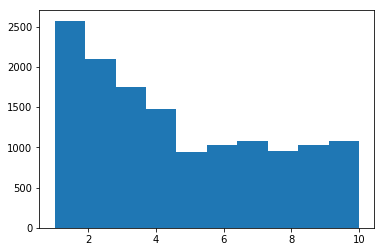

[2573.608 2095.2   1750.034 1479.679  945.452 1024.445 1079.237  951.194
 1030.265 1084.205]
All Hits 1.4013E+04
[5392223.481599452, 3666671.236800405, 2589488.559086526, 2433222.8308156473, 1980911.030399918, 1654573.145368111, 968563.574139946, 1105618.9484649901, 2448000.487951649, 1992941.6687999205, 1664621.840596114, 979981.8864099487, 1117018.4643249928, 0]
All Doublets 2.7994E+07


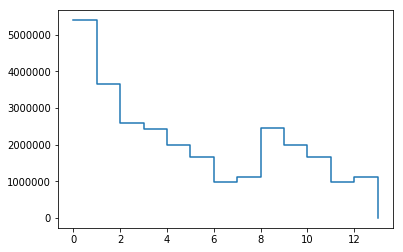

All triplets [9436574428.398449, 5425496428.998095, 5098088475.124949, 3466661654.17527, 2492702962.914902, 1045309646.0640776, 2029334400.538017, 5129050622.356299, 3487715680.4169817, 2522089222.7194767, 1062501261.1551037, 2053258048.4061267, 0]
4.3249E+10


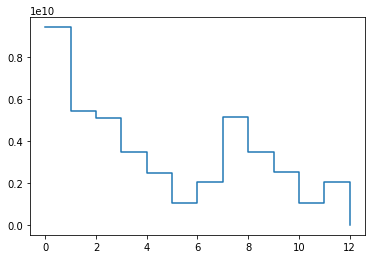

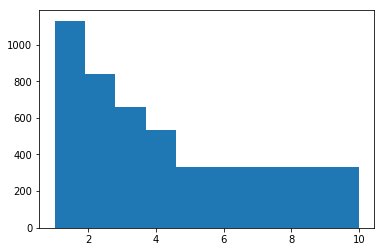

In [13]:
#print hits[hits['tkId']==3].head(50)
n,b,p = plt.hist(rawHits['seq'],weights=rawHits['norm'])
plt.show()
print n 
print 'All Hits', '{:.4E}'.format(np.sum(n))
doublets = [n[0]*n[1],n[1]*n[2],n[2]*n[3],
            n[0]*n[4],n[1]*n[4],n[2]*n[4],n[4]*n[5],n[5]*n[6],
            n[0]*n[7],n[1]*n[7],n[2]*n[7],n[7]*n[8],n[8]*n[9],0
           ]
print doublets
print 'All Doublets', '{:.4E}'.format(np.sum(doublets))
xy = np.arange(0.,14.,1.)
plt.step(xy,doublets,where='post')
plt.show()
triplets = [n[0]*n[1]*n[2],n[1]*n[2]*n[3],
            n[0]*n[1]*n[4],n[1]*n[2]*n[4],
            n[0]*n[4]*n[5],n[4]*n[5]*n[6],
            n[1]*n[4]*n[5],
            n[0]*n[1]*n[7],n[1]*n[2]*n[7],
            n[0]*n[7]*n[8],n[7]*n[8]*n[9],
            n[1]*n[7]*n[8],0
           ]
print 'All triplets', triplets
print '{:.4E}'.format(np.sum(triplets))
xy = np.arange(0.,len(triplets),1)
plt.step(xy,triplets,where='post')
plt.show()


plt.hist(hits['seq'],weights=hits['norm'])
plt.show()

1130010 841967 660647 531391 660653 663638 660178


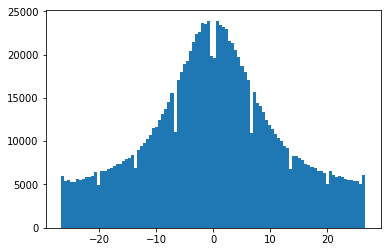

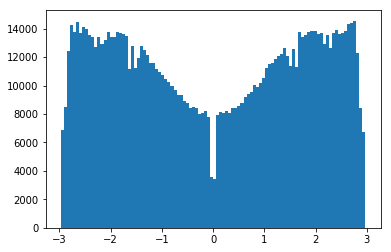

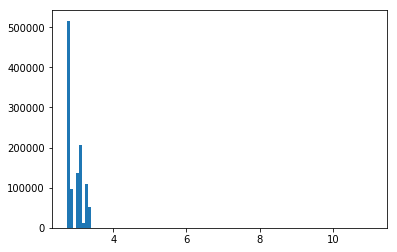

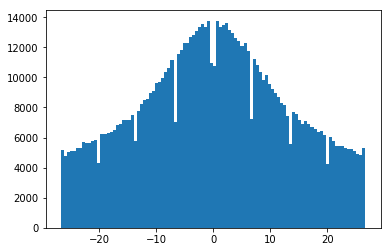

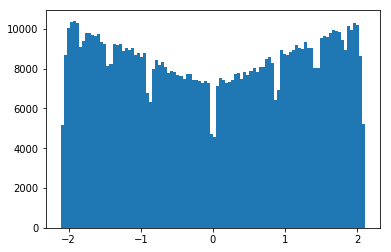

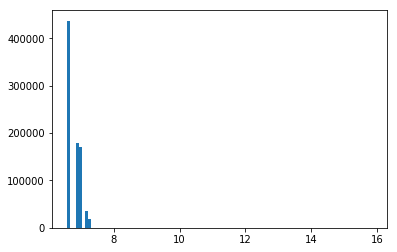

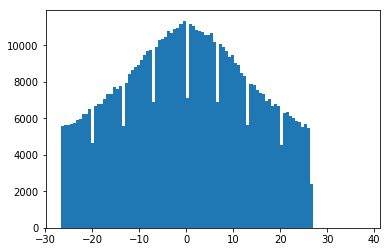

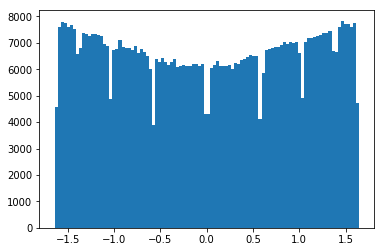

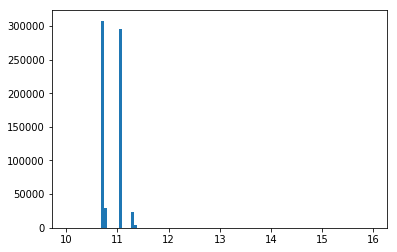

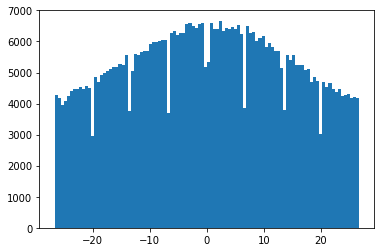

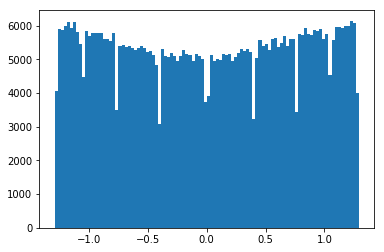

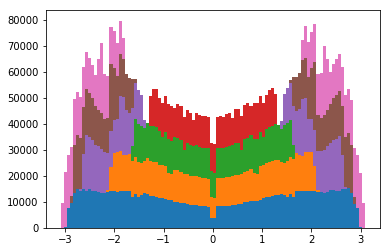

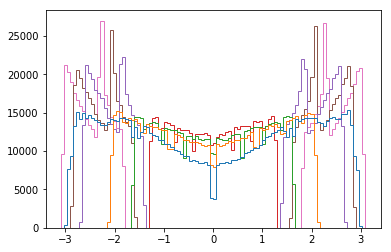

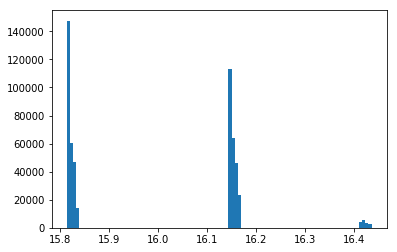

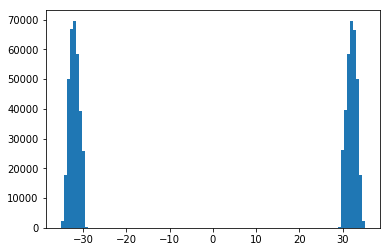

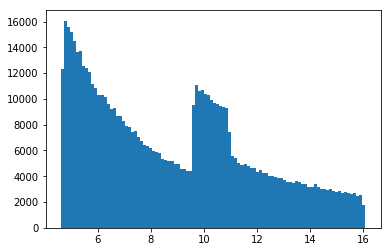

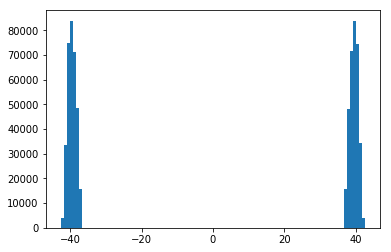

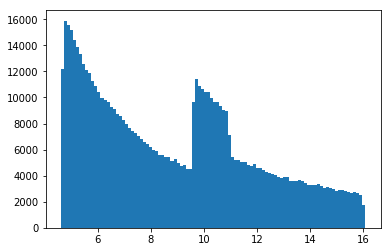

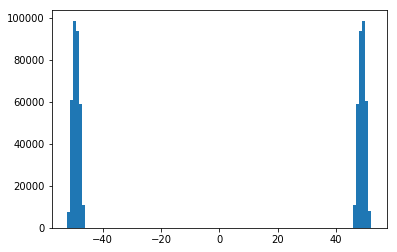

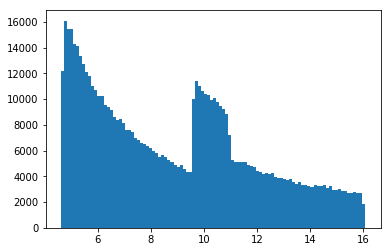

In [14]:
hb1 = hits.query('seq==1')
hb2 = hits.query('seq==2')
hb3 = hits.query('seq==3')
hb4 = hits.query('seq==4')
hf1 = hits.query('seq==5 or seq==8')
hf2 = hits.query('seq==6 or seq==9')
hf3 = hits.query('seq==7 or seq==10')

print len(hb1), len(hb2), len(hb3), len(hb4), len(hf1), len(hf2), len(hf3)
plt.hist(hb1['zg'],log=False, bins=100)
plt.show()
plt.hist(hb1['eta'],log=False, bins=100)
plt.show()
plt.hist(hb1['rg'],log=False, bins=100)
plt.show()
plt.hist(hb2['zg'],log=False, bins=100)
plt.show()
plt.hist(hb2['eta'],log=False, bins=100)
plt.show()
plt.hist(hb2['rg'],log=False, bins=100)
plt.show()
plt.hist(hb3['zg'],log=False, bins=100)
plt.show()
plt.hist(hb3['eta'],log=False, bins=100)
plt.show()
plt.hist(hb3['rg'],log=False, bins=100)
plt.show()
plt.hist(hb4['zg'],log=False, bins=100)
plt.show()
plt.hist(hb4['eta'],log=False, bins=100)
plt.show()
data = [hb1['eta'],hb2['eta'],hb3['eta'],hb4['eta'],hf1['eta'],hf2['eta'],hf3['eta']]
plt.hist(data,log=False, bins=100, histtype='barstacked')
plt.show()
plt.hist(data,log=False, bins=100, histtype='step')
plt.show()


plt.hist(hb4['rg'],log=False, bins=100)
plt.show()
plt.hist(hf1['zg'],log=False, bins=100)
plt.show()
plt.hist(hf1['rg'],log=False, bins=100)
plt.show()
plt.hist(hf2['zg'],log=False, bins=100)
plt.show()
plt.hist(hf2['rg'],log=False, bins=100)
plt.show()
plt.hist(hf3['zg'],log=False, bins=100)
plt.show()
plt.hist(hf3['rg'],log=False, bins=100)
plt.show()


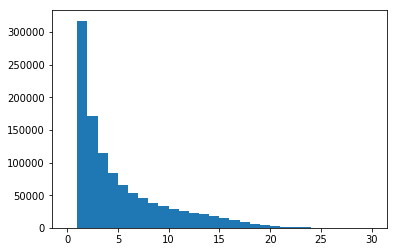

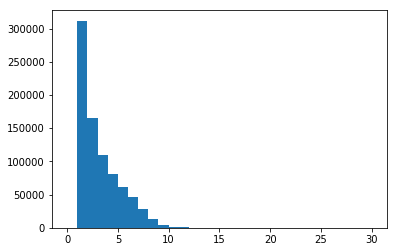

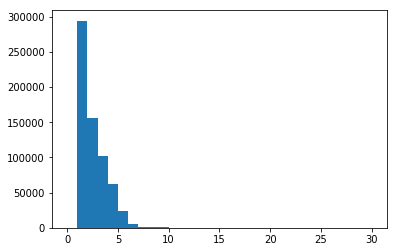

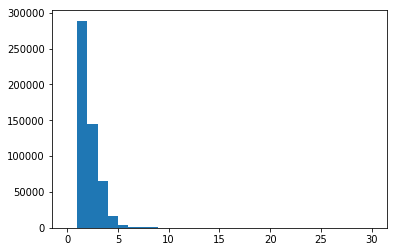

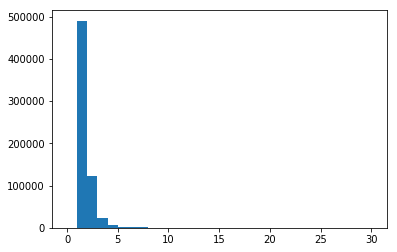

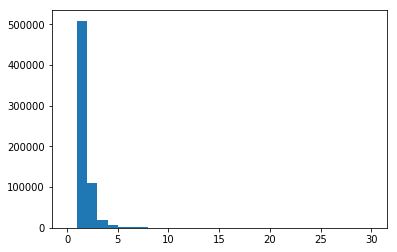

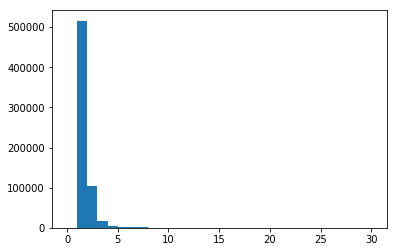

In [15]:
plt.hist(hb1['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hb2['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hb3['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hb4['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hf1['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hf2['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hf3['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()

In [16]:
print 'min/max'
print hb1.agg(['min','max'])
print hb2.agg(['min','max'])
print hb3.agg(['min','max'])
print hb4.agg(['min','max'])
print hf1.agg(['min','max'])
print hf2.agg(['min','max'])
print hf3.agg(['min','max'])

min/max
       ev   ind  det   charge      xg      yg       zg       rg   iphi  xsize  \
min     1     0    0     2019 -3.1587 -3.3743 -26.6751   2.7388 -32766  -1023   
max  1000  4382   95  7570745  6.6091  3.3743  26.6750  11.0548  32765   1023   

     ...      tkId      pt      z0   r0   n1       phi       eta  seq  \
min  ...         0     401 -147338    0    0 -3.141557 -2.971983    1   
max  ...    142826  292338  149881  999  206  3.141416  2.971979    1   

         trackID   norm  
min     10000002  0.001  
max  10000113902  0.001  

[2 rows x 21 columns]
       ev   ind  det   charge      xg      yg       zg       rg   iphi  xsize  \
min     1   855   96     4021 -6.9806 -7.2495 -26.6751   6.5775 -32767  -1023   
max  1000  8049  319  5558487  6.9806  7.2495  26.6750  15.8274  32767   1023   

     ...      tkId      pt      z0   r0   n1       phi       eta  seq  \
min  ...         0     401 -147949    0    1 -3.141593 -2.108088    2   
max  ...    142826  292338  149881  9

In [41]:
def build(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['zg'],
                    'r'+n : hh['rg'],
                    'phi'+n : hh['phi'],
                    'ys'+n : hh['ysize'],
                    'pt'+n : hh['pt'],
                    'det'+n : hh['det'],
                    'trackID' : hh['trackID'],
                    'tkz'+n : hh['z0']/10000.,
                    'seq'+n : hh['seq'],
                       })

def buildXYZ(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['zg'],
                    'x'+n : hh['xg'],
                    'y'+n : hh['yg'],
                    'pt'+n : hh['pt'],
                    'det'+n : hh['det'],
                    'phi'+n : hh['phi'],
                    'trackID' : hh['trackID']
                       })


In [42]:
def fishBone(hi,hj) :
    mpt=600
#    maxc = 1000./(mpt*87.)
    fb = pd.merge(pd.merge(buildXYZ(hi,'0'),buildXYZ(hj,'1'),on='trackID'),buildXYZ(hj,'2'),on='trackID')
#    pc = phicut(quadc['r1'],quadc['r2'],maxc)
#  d1 = (quadc['phi2']-quadc['phi1'])/pc
    cut = np.logical_and(abs(fb['phi0']-fb['phi1'])<0.05,abs(fb['phi0']-fb['phi2'])<0.05)
    cut = np.logical_and(cut,fb['pt0']>mpt)
    return fb[np.logical_and(cut,fb['det1']<fb['det2'])]
    
def sdiff(fb) :
    n1 = (fb['x1']-fb['x0'])*(fb['x1']-fb['x0'])+\
    (fb['y1']-fb['y0'])*(fb['y1']-fb['y0'])+\
    (fb['z1']-fb['z0'])*(fb['z1']-fb['z0'])
    n2 = (fb['x2']-fb['x0'])*(fb['x2']-fb['x0'])+\
    (fb['y2']-fb['y0'])*(fb['y2']-fb['y0'])+\
    (fb['z2']-fb['z0'])*(fb['z2']-fb['z0'])
    pr = (fb['x1']-fb['x0'])*(fb['x2']-fb['x0'])+\
      (fb['y1']-fb['y0'])*(fb['y2']-fb['y0'])+\
      (fb['z1']-fb['z0'])*(fb['z2']-fb['z0'])
    return pr/np.sqrt(n1*n2)

In [43]:
def plotFB(h1,h2) :
  f12 = fishBone(h1,h2)
  # print f12.head()
  d = sdiff(f12)
  plt.hist(d, bins=100,log=True)
  plt.show()
  plt.hist(d[d>.995], bins=100,log=True)
  plt.show()
  plt.hist(d[d>.9999], bins=100,log=True)
  plt.show()

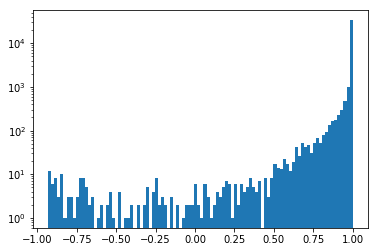

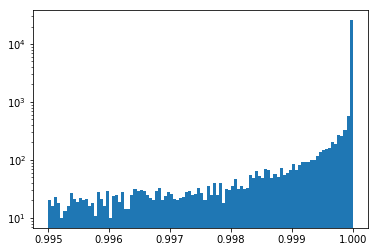

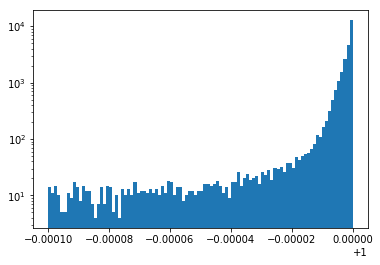

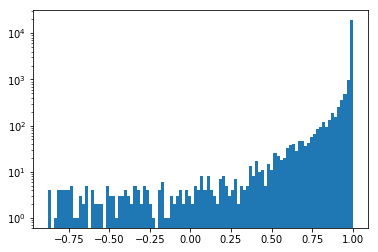

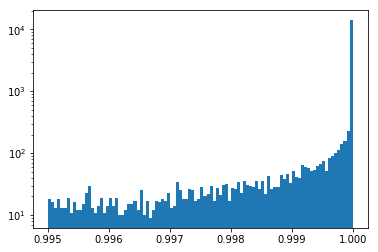

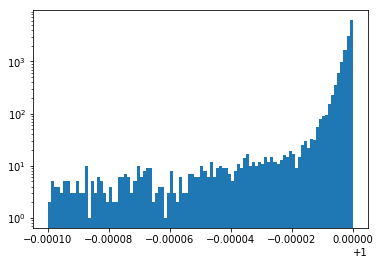

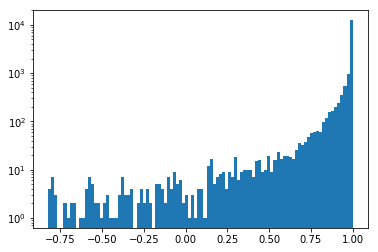

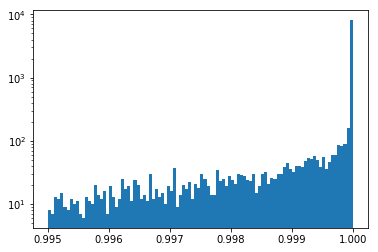

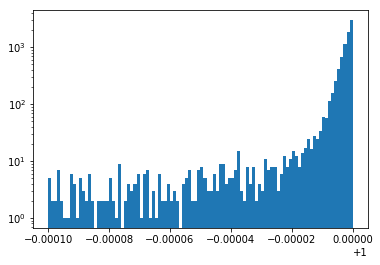

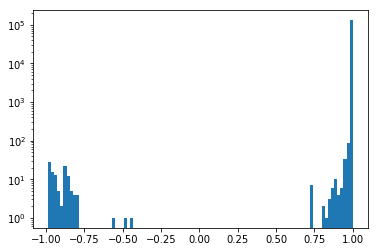

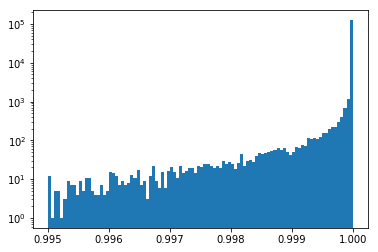

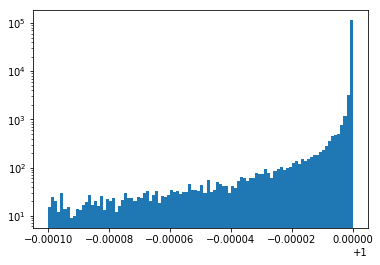

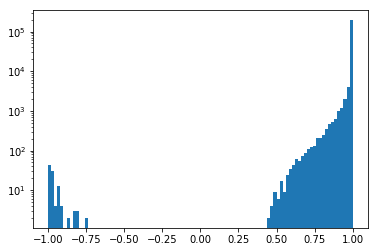

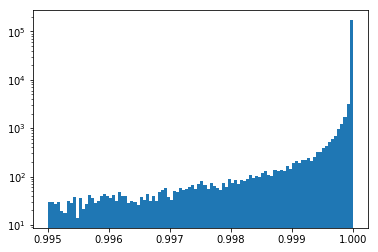

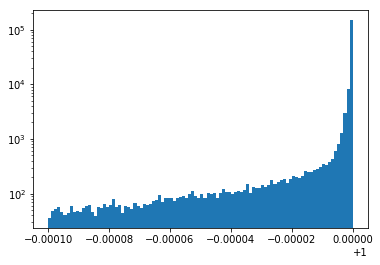

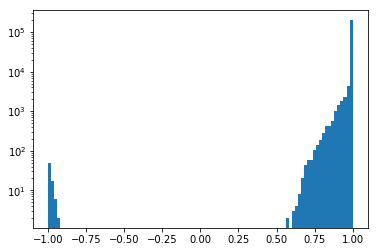

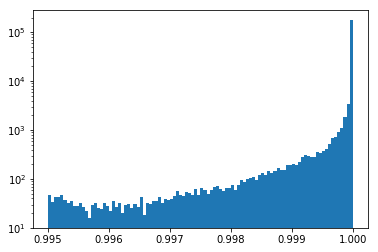

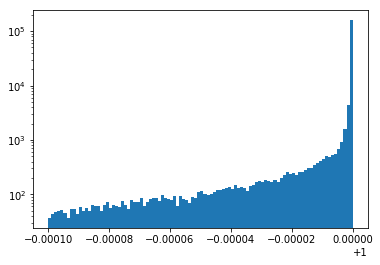

In [44]:
plotFB(hb1,hb2)
plotFB(hb2,hb3)
plotFB(hb3,hb4)
plotFB(hb1,hf1)
plotFB(hf1,hf2)
plotFB(hf2,hf3)

In [45]:
t12 = pd.merge(build(hb1,'1'),build(hb2,'2'),on='trackID')
t23 = pd.merge(build(hb2,'1'),build(hb3,'2'),on='trackID')
t34 = pd.merge(build(hb3,'1'),build(hb4,'2'),on='trackID')

print 'doublets'
print len(t12)
print len(t23)
print len(t34)
t11 = pd.merge(build(hb1,'1'),build(hf1,'2'),on='trackID')
print len(t11)

t21 = pd.merge(build(hb2,'1'),build(hf1,'2'),on='trackID')
print len(t21)
t31 = pd.merge(build(hb3,'1'),build(hf1,'2'),on='trackID')
print len(t31)

t12f = pd.merge(build(hf1,'1'),build(hf2,'2'),on='trackID')
print len(t12f)
t23f = pd.merge(build(hf2,'1'),build(hf3,'2'),on='trackID')
print len(t23f)

lpairs = [t12,t23,t34,t11,t21,t31,t12f,t23f]

print 'triplets and quads'
t123 = pd.merge(t12,build(hb3,'3'),on='trackID')
print len(t123)
t1234 = pd.merge(t123,build(hb4,'4'),on='trackID')
print len(t1234)
t1231 = pd.merge(t123,build(hf1,'4'),on='trackID')
print len(t1231)
t121 = pd.merge(t12,build(hf1,'3'),on='trackID')
t1212 = pd.merge(t121,build(hf2,'4'),on='trackID')
print len(t1212)
t11 = pd.merge(build(hb1,'1'),build(hf1,'2'),on='trackID')
t112 = pd.merge(t11,build(hf2,'3'),on='trackID')
t1123 = pd.merge(t112,build(hf3,'4'),on='trackID')
print len(t1123)
print 'pentuplets'
t12123 = pd.merge(t1212,build(hf3,'5'),on='trackID')
print len(t12123)

# try to get triplets in gap
print 'triplets'
t1230 = pd.merge(t123,build(hb4,'4'),on='trackID',how='left')
t1230 = t1230[t1230.isnull()['z4']]
print len(t1230)
t1230 = pd.merge(t1230,build(hf1,'5'),on='trackID',how='left')
t1230 = t1230[t1230.isnull()['z5']]
print len(t1230)

qall = pd.concat([t1234,t1231,t1212,t1123])
print len(qall)
print t1234.head()
print t1231.head()
print t1212.head()
print t1123.head()
print t1230.head()
print t12123.head()

doublets
1046526
916430
760030
808590
436318
165447
934476
942520
triplets and quads
1567123
4597455
1070839
888560
1707720
pentuplets
1229586
triplets
197639
82324
8264574
   det1      phi1  pt1      r1  seq1     tkz1   trackID  ys1      z1  det2  \
0    51 -2.743778  428  3.0782     1 -10.6632  10108743   38 -3.1901   149   
1    51 -2.743778  428  3.0782     1 -10.6632  10108743   38 -3.1901   149   
2    51 -2.743778  428  3.0782     1 -10.6632  10108743   38 -3.1901   220   
3    51 -2.743778  428  3.0782     1 -10.6632  10108743   38 -3.1901   220   
4    51 -2.743778  428  3.0782     1 -10.6632  10108743   38 -3.1901   276   

    ...     ys3       z3  det4      phi4  pt4       r4  seq4     tkz4  ys4  \
0   ...      15  16.2390   896  2.790262  428  15.8156     4 -10.6632   29   
1   ...      15 -26.1485   896  2.790262  428  15.8156     4 -10.6632   29   
2   ...      15  16.2390   896  2.790262  428  15.8156     4 -10.6632   29   
3   ...      15 -26.1485   896  2.790262  428 

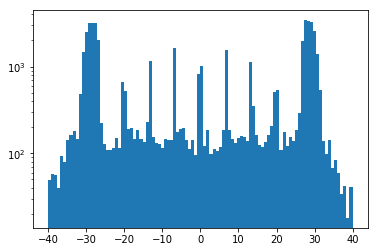

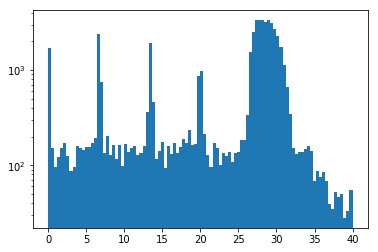

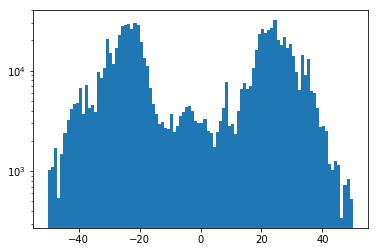

In [46]:
hole = zAtR(t1230[t1230['pt3']>600],16)
plt.hist(hole[abs(hole)<40],log=True, bins=100)
plt.show()
plt.hist(abs(hole[abs(hole)<40]),log=True, bins=100)
plt.show()
penta = zAtR(t12123[t12123['pt3']>600],6.5)
plt.hist(penta[abs(penta)<50],log=True, bins=100)
plt.show()

In [47]:
def plotTriplets(quad,mpt,kq) :
    
  print " "
  print "New QUAD",kq
  print " "
    
    
  d1 = (quad['r1']*quad['z2']-quad['z1']*quad['r2'])/(quad['r1']-quad['r2'])
  d2 = (quad['r2']*quad['z3']-quad['z2']*quad['r3'])/(quad['r2']-quad['r3'])
  d3 = (quad['r3']*quad['z4']-quad['z3']*quad['r4'])/(quad['r3']-quad['r4'])
  
  z0cut = np.logical_and(abs(d1)<10.,np.logical_and(abs(d2)<10.,abs(d3)<10.))

  quadc = quad[np.logical_and(z0cut,quad['pt1']>mpt)]

#  print 'dpt'
#  plt.hist(quad['pt1']-quad['pt2'],log=True, bins=100)
#  plt.show()
#  plt.hist(quad['pt2']-quad['pt3'],log=True, bins=100)
#  plt.show()
#  plt.hist(quad['pt3']-quad['pt4'],log=True, bins=100)
#  plt.show()


  print 'delta123', len(quadc)
  
#dt,dtn = ml(t123['tpt'],t123['tpz'],t123['tpt2'],t123['tpz2'])
#plt.hist(dt[dt<0.1], log=True, bins=100)
#plt.show()
#plt.hist(dtn[dtn<0.1], log=True, bins=100)
#plt.show()

    
  thcut = alignRZ(quadc,'r',0.6,True)
  pzcut = alignRZ(quadc,'phi',1.0,True)
  thcut2 = alignRPZ(quadc,'r',True)
  pzcut2 = alignRPZ(quadc,'phi',True)

  dc = dca(quadc,True)
  curv1 = dca(quadc,True,True)
  field = curv1-1/(0.087*quadc['pt1'])
  print 'field'
  plt.hist(field[abs(field)<5],log=True, bins=100)
  plt.show()
  print 'thcut,pzcut,dcacut',len(thcut)
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.3],log=True, bins=100)
  plt.show()

  print 'thcut2,pzcut2',len(thcut2)
  plt.hist(thcut2[abs(thcut2)<0.6],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.2],log=True, bins=100)
  plt.show()
 
  print 'delta234'

  thcut = alignRZ(quadc,'r',0.6,False)
  pzcut = alignRZ(quadc,'phi',1.0,False)
  thcut2 = alignRPZ(quadc,'r',False)
  pzcut2 = alignRPZ(quadc,'phi',False)
  dc = dca(quadc,False)
  curv2 = dca(quadc,False,True)
  field =curv2 -1/(0.087*quadc['pt1'])
  print 'field'
  plt.hist(field[abs(field)<5],log=True, bins=100)
  plt.show()
  print 'delta curv'
  dcu = curv2-curv1
  plt.hist(dcu[abs(dcu)<0.15],log=True, bins=100)
  plt.show()  
  print 'thcut,pzcut,dcacut',len(thcut)
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.3],log=True, bins=100)
  plt.show()

    
  print 'thcut2,pzcut2',len(thcut2)
  plt.hist(thcut2[abs(thcut2)<0.6],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.2],log=True, bins=100)
  plt.show()


In [48]:
kq=0
def plotDoublets(quad,mpt,kq) :
  quadc = quad[quad['pt1']>mpt]

  maxc = 1000./(mpt*87.78)

  print " "
  print "New QUAD",kq
  print " "
    
  print 'dphi'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[abs(d1)<.1], bins=100,log=True)
  plt.show()
  d2 = quadc['phi3']-quadc['phi2']
  plt.hist(d2[abs(d2)<.1], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[abs(d3)<.1], bins=100,log=True)
  plt.show()

  pcut = np.logical_and(abs(d1)<0.05,np.logical_and(abs(d2)<0.05,abs(d3)<0.05))


  print 'dphiNor'
    
  pc = phicut(quadc['r1'],quadc['r2'],maxc)
  d1 = (quadc['phi2']-quadc['phi1'])/pc
  plt.hist(d1[abs(d1)<2.], bins=100,log=True)
  plt.show()
  pc = phicut(quadc['r2'],quadc['r3'],maxc)
  d2 = (quadc['phi3']-quadc['phi2'])/pc
  plt.hist(d2[abs(d2)<2.], bins=100,log=True)
  plt.show()
  pc = phicut(quadc['r3'],quadc['r4'],maxc)
  d3 = (quadc['phi4']-quadc['phi3'])/pc
  plt.hist(d3[abs(d3)<2.], bins=100,log=True)
  plt.show()


  print 'zinner'
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print 'dz'
  d1 = quadc['z2']-quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z3']-quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z4']-quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print 'z0'
  d1 = (quadc['r1']*quadc['z2']-quadc['z1']*quadc['r2'])/(quadc['r1']-quadc['r2'])
  plt.hist(d1[np.logical_and(pcut,abs(d1)<50)], bins=100,log=True)
  plt.show()
  d2 = (quadc['r2']*quadc['z3']-quadc['z2']*quadc['r3'])/(quadc['r2']-quadc['r3'])
  plt.hist(d2[np.logical_and(pcut,abs(d2)<50)], bins=100,log=True)
  plt.show()
  d3 = (quadc['r3']*quadc['z4']-quadc['z3']*quadc['r4'])/(quadc['r3']-quadc['r4'])
  plt.hist(d3[np.logical_and(pcut,abs(d3)<50)], bins=100,log=True)
  plt.show()
  

  pcut = np.logical_and(abs(d1)<10.,np.logical_and(abs(d2)<10.,abs(d3)<10.))


  print 'dr'
  d1 = quadc['r2']-quadc['r1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<20)], bins=100,log=True)
  plt.show()
  d2 = quadc['r3']-quadc['r2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<20)], bins=100,log=True)
  plt.show()
  d3 = quadc['r4']-quadc['r3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<20)], bins=100,log=True)
  plt.show()

  print 'dphi zcut'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<.1)], bins=100,log=True)
  plt.show()
  d2 = quadc['phi3']-quadc['phi2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<.1)], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<.1)], bins=100,log=True)
  plt.show()

  print 'zinner zcut'
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print 'module'
  d1 = quadc['det1']
  plt.hist(d1[pcut], range=[0,96], bins=96, log=False)
  plt.show()
  d2 = quadc['det2']
  plt.hist(d2[pcut], range=[0,2000], bins=2000, log=False)
  plt.show()
  d3 = quadc['det3']
  plt.hist(d3[pcut], range=[0,2000], bins=2000, log=False)
  plt.show()



  norm = 1./8.
  print 'dysize'
  d1 = (quadc['ys2']-quadc['ys1'])*norm
  c = np.logical_and(quadc['ys2']>0,quadc['ys1']>0)
  plt.hist(d1[np.logical_and(pcut,c)], range=[-8,8],bins=32,log=True)
  plt.show()
  c = np.logical_and(quadc['ys2']>0,quadc['ys3']>0)
  d2 = (quadc['ys3']-quadc['ys2'])*norm
  plt.hist(d2[np.logical_and(pcut,c)], range=[-6,6],bins=26,log=True)
  plt.show()
  c = np.logical_and(quadc['ys4']>0,quadc['ys3']>0)
  d3 = (quadc['ys4']-quadc['ys3'])*norm
  plt.hist(d3[np.logical_and(pcut,c)], range=[-6,6],bins=26,log=True)
  plt.show()

    
  print 'ysize'
  d1 = quadc['ys1']*norm
  plt.hist(d1[pcut], bins=30,range=[0,30],log=True)
  plt.show()
  d2 = quadc['ys2']*norm
  plt.hist(d2[pcut], bins=30,range=[0,30],log=True)
  plt.show()
  d3 = quadc['ys3']*norm
  plt.hist(d3[pcut], bins=30,range=[0,30],log=True)
  plt.show()
 
  print 'ys-pred'
  th = 0.0285
  ptc = 0.015
  fac = th/ptc
  d1 = fac*(quadc['z1']-quadc['z2'])/(quadc['r1']-quadc['r2'])
  d1 = quadc['ys1']*norm - abs(d1)
  plt.hist(d1[np.logical_and(pcut,quadc['ys1']>0)], range=[-8,8],bins=32,log=True)
  plt.show()
  d2 = fac*(quadc['z3']-quadc['z2'])/(quadc['r3']-quadc['r2'])
  d2 = quadc['ys2']*norm - abs(d2)
  plt.hist(d2[np.logical_and(pcut,quadc['ys2']>0)], range=[-8,8],bins=32,log=True)
  plt.show()
  d3 = fac*(quadc['z3']-quadc['z4'])/(quadc['r3']-quadc['r4'])
  d3 = quadc['ys3']*norm - abs(d3)
  plt.hist(d3[np.logical_and(pcut,quadc['ys3']>0)], range=[-8,8],bins=32,log=True)
  plt.show()

    

In [49]:
doTriplets = False
doDoublets = False

In [50]:
kq=0
if (doTriplets) :
  for quad in [t1234,t1231,t1212,t1123] :
    plotTriplets(quad,600, kq)
    kq+=1

In [51]:
kq=0
if (doDoublets) :
  for quad in [t1234,t1231,t1212,t1123] :
    plotDoublets(quad,500,kq)
    kq+=1

In [127]:
def plotPairs(quad,mpt,kp) :
  quadc = quad[quad['pt1']>mpt]

  maxc = 1000./(mpt*87.78)

  print " "
  print "NEW PAIR",kp, quad['seq1'][0], quad['seq2'][0]
  print " " 
    
  print 'dphi'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[abs(d1)<.1], bins=100,log=True)
  plt.grid()
  plt.show()

  pcut = abs(d1)<0.06


  print 'dphiNor'
    
  pc = phicut(quadc['r1'],quadc['r2'],maxc)
  d1 = (quadc['phi2']-quadc['phi1'])/pc
  plt.hist(d1[abs(d1)<2.5], bins=100,log=True)
  plt.grid()
  plt.show()


  print 'zinner'
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()

  print 'dz'
  d1 = quadc['z2']-quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()

  print 'z0'
  d1 = (quadc['r1']*quadc['z2']-quadc['z1']*quadc['r2'])/(quadc['r1']-quadc['r2'])
  plt.hist(d1[np.logical_and(pcut,abs(d1)<50)], bins=100,log=True)
  plt.grid()
  plt.show()
  
  res=40./10000.
  err1 = quadc['r2'].copy()
  err1.where(quadc['seq1']<5,quadc['z2'], inplace=True)
  err2 = quadc['r1'].copy()
  err2.where(quadc['seq2']<5,quadc['z1'], inplace=True)
  err3 = d1.where(np.logical_or(quadc['seq1']>4,quadc['seq2']>4),0)
  err = np.sqrt(err1*err1+err2*err2+err3*err3)
  err = res*err/abs(quadc['r1']-quadc['r2'])
     
  pcut = np.logical_and(pcut,abs(d1)<12.)

  print 'z0 res'  
  dz = d1 - quadc['tkz1']
  plt.hist(dz[pcut], bins=100,range=[-2.,2.],log=True)
  plt.grid()
  plt.show()
  plt.hist(dz[pcut], bins=100,range=[-0.4,0.4],log=True)
  plt.grid()
  plt.show()
 
  print 'z0 pool' 
  plt.hist(dz[pcut]/err, bins=100,range=[-6.,6.],log=True)
  plt.grid()
  plt.show()
    
  # Define model function to be used to fit to the data above:
  def gauss(x, *p):
    A1, mu1, sigma1 = p
    return A1*np.exp(-(x-mu1)**2/(2.*sigma1**2))

  def gauss2(x, *p):
    A1, mu1, sigma1, A2, mu2, sigma2,  = p
    return A1*(np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2)))


  # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
  p0 = [1., 0., 1.,] # 0.1, 0., 10.]
  hist, bin_edges = np.histogram(dz[pcut]/err, bins=100,range=[-6.,6.], density=False)
  bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
  try :
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0, sigma=np.sqrt(hist))
    p0 = [coeff[0], coeff[1], coeff[2], 0.1, coeff[1], 10*coeff[2]]
    coeff, var_matrix = curve_fit(gauss2, bin_centres, hist, p0=p0, sigma=np.sqrt(hist))

    print coeff  
    # Get the fitted curve
    hist_fit = gauss2(bin_centres, *coeff)
    sec = [coeff[0]*coeff[3], coeff[4], coeff[5]]
    hist_sec = gauss(bin_centres, *sec)

    plt.step(bin_centres, hist, label='')
    plt.plot(bin_centres, hist_fit, label='')
    plt.plot(bin_centres, hist_sec, label='')
    plt.grid()
    plt.show()

  except :
    print 'fit failed'


    
  print 'dr'
  d1 = quadc['r2']-quadc['r1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<20)], bins=100,log=True)
  plt.show()

  print 'dphi zcut'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<.1)], bins=100,log=True)
  plt.grid()
  plt.show()

  print 'zinner zcut'
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.grid()
  plt.show()

    
  print 'module'
  d1 = quadc['det1']
  plt.hist(d1[pcut], range=[0,96], bins=96, log=False)
  plt.show()


  norm = 1./8.
  print 'dysize'
  d1 = (quadc['ys2']-quadc['ys1'])*norm
  c = np.logical_and(quadc['ys2']>0,quadc['ys1']>0)
  plt.hist(d1[np.logical_and(pcut,c)], range=[-8,8],bins=32,log=True)
  plt.grid()
  plt.show()
    
  print 'ysize'
  d1 = quadc['ys1']*norm
  plt.hist(d1[pcut], bins=30,range=[0,20],log=True)
  plt.grid()
  plt.show()
 
  print 'ys-pred'
  th = 0.0285
  ptc = 0.015
  fac = th/ptc
  d1 = fac*(quadc['z1']-quadc['z2'])/(quadc['r1']-quadc['r2'])
  d1 = quadc['ys1']*norm - abs(d1)
  plt.hist(d1[np.logical_and(pcut,quadc['ys1']>0)], range=[-8,8],bins=32,log=True)
  plt.grid()
  plt.show()

    

 
NEW PAIR 0 1 2
 
dphi


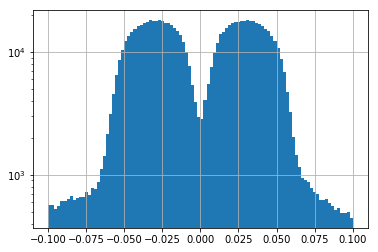

dphiNor


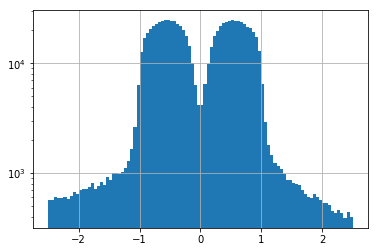

zinner


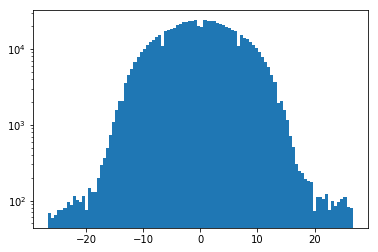

dz


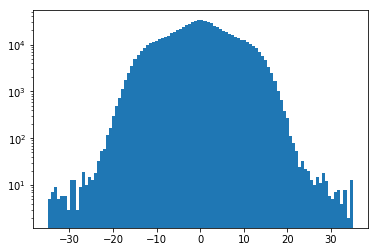

z0


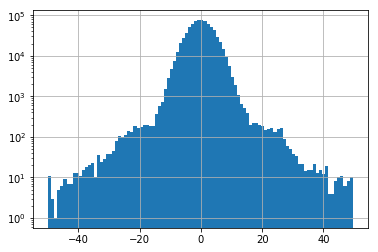

z0 res


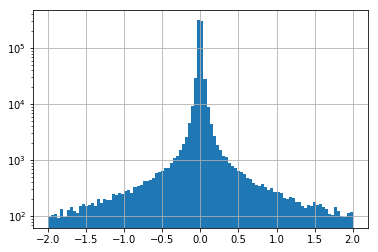

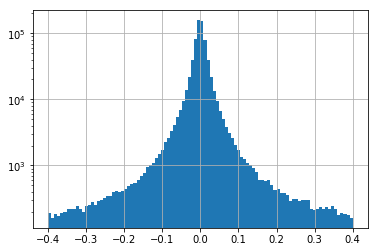

z0 pool


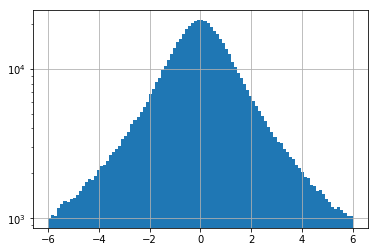

[ 1.54734142e+04 -9.07024500e-03 -1.02425257e+00  3.22808634e-01
 -1.91389051e-02 -3.13970276e+00]


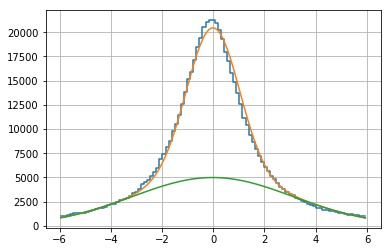

dr


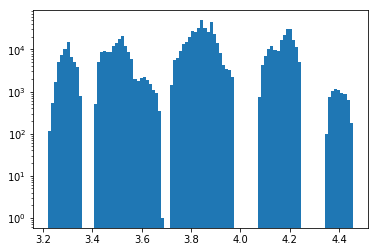

dphi zcut


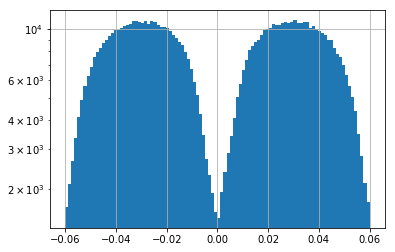

zinner zcut


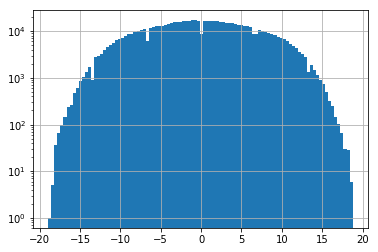

module


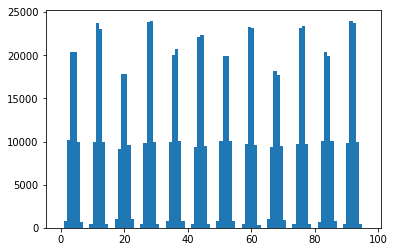

dysize


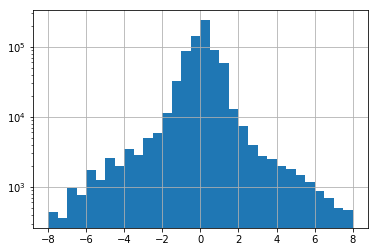

ysize


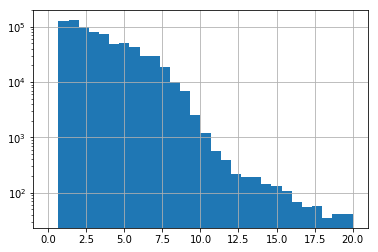

ys-pred


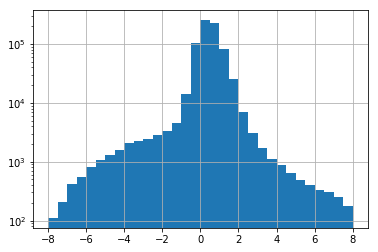

 
NEW PAIR 1 2 3
 
dphi


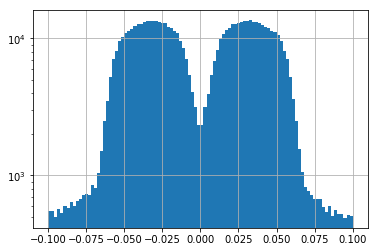

dphiNor


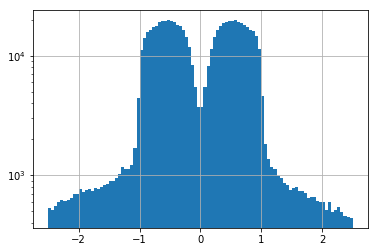

zinner


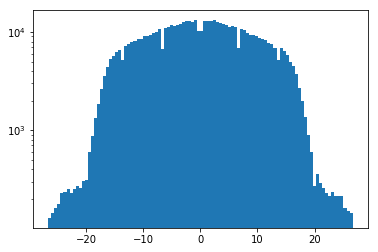

dz


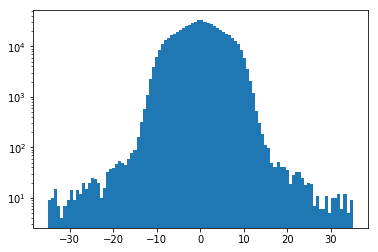

z0


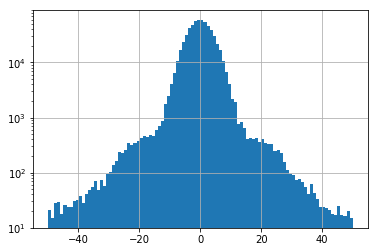

z0 res


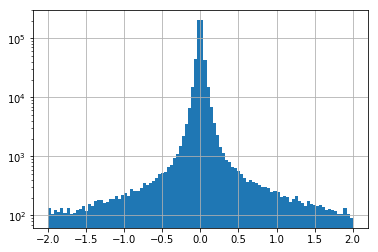

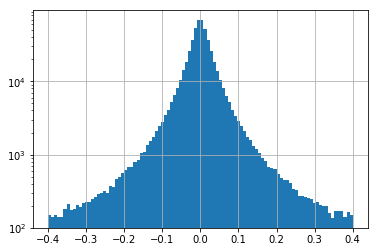

z0 pool


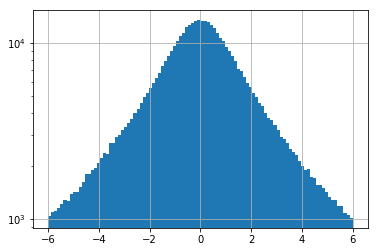

[ 8.58488450e+03 -5.52044392e-04 -1.09982777e+00  5.25405508e-01
 -1.26386024e-02  3.30929906e+00]


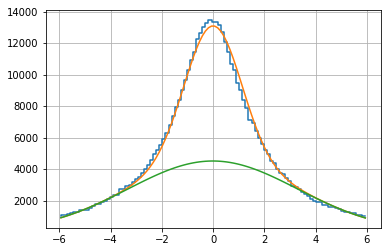

dr


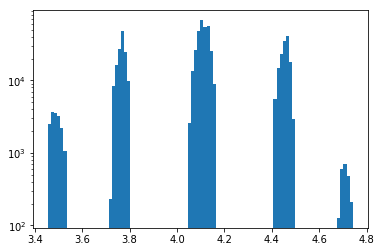

dphi zcut


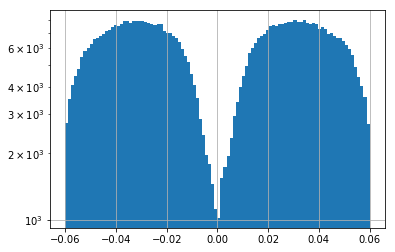

zinner zcut


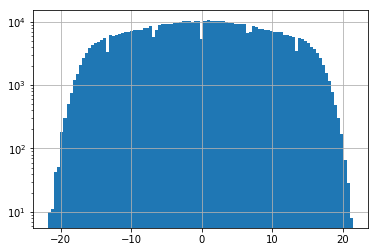

module


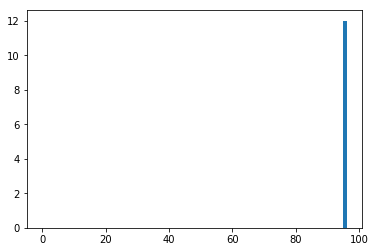

dysize


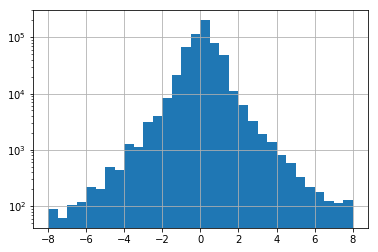

ysize


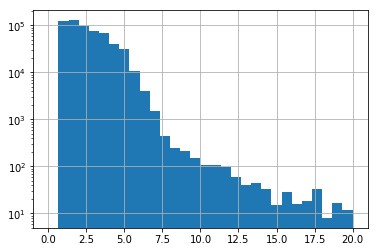

ys-pred


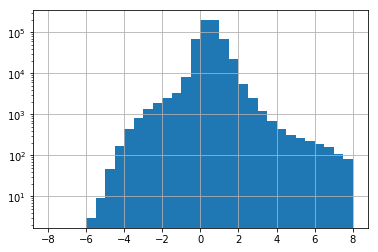

 
NEW PAIR 2 3 4
 
dphi


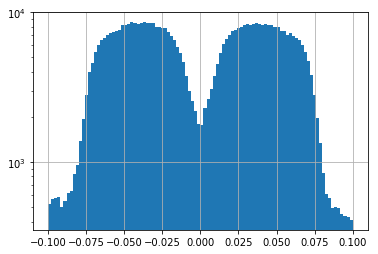

dphiNor


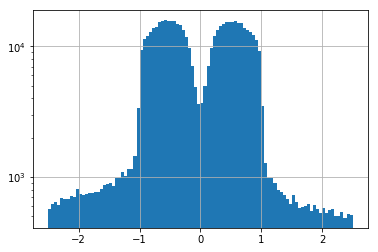

zinner


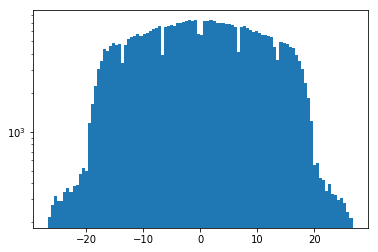

dz


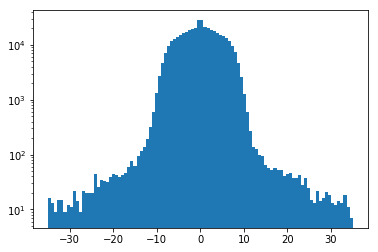

z0


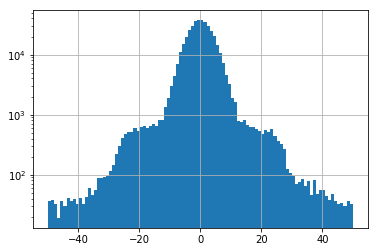

z0 res


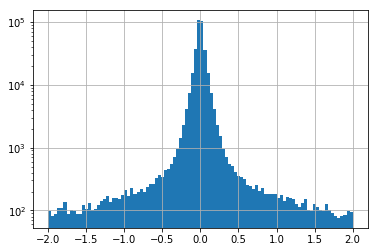

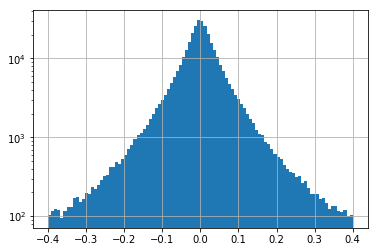

z0 pool


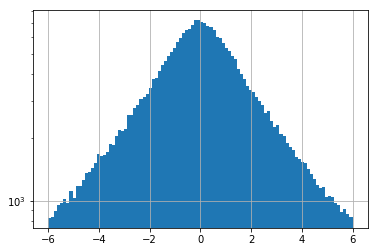

[ 3.97580543e+03 -1.14482719e-02 -1.15552770e+00  7.37792181e-01
 -2.18369479e-02  3.60456865e+00]


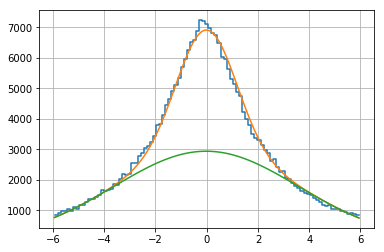

dr


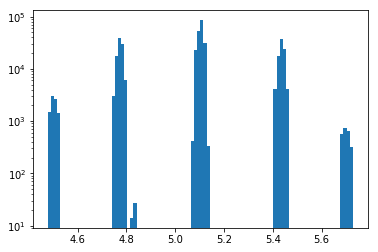

dphi zcut


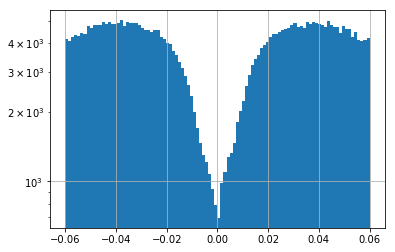

zinner zcut


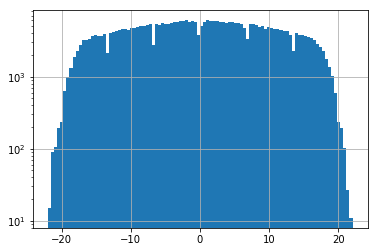

module


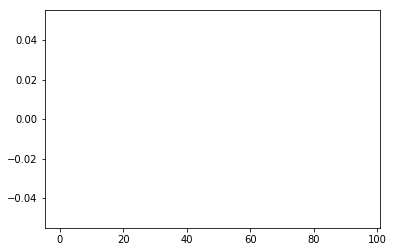

dysize


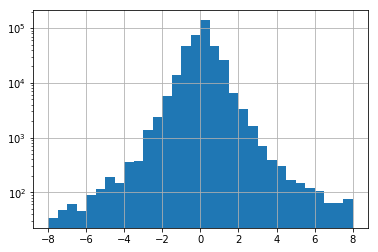

ysize


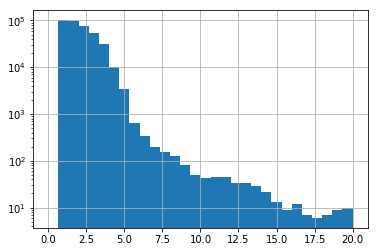

ys-pred


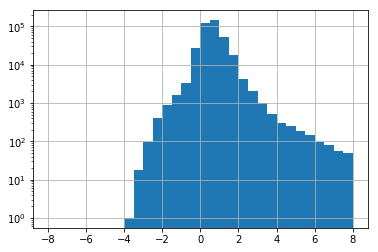

 
NEW PAIR 3 1 8
 
dphi


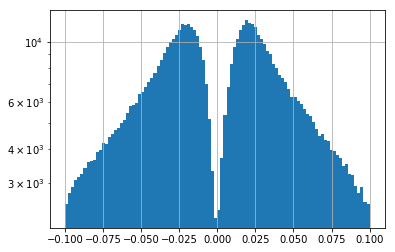

dphiNor


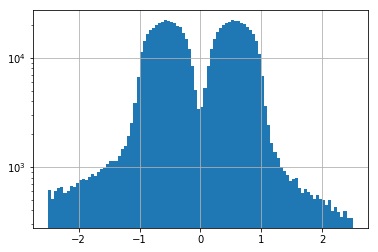

zinner


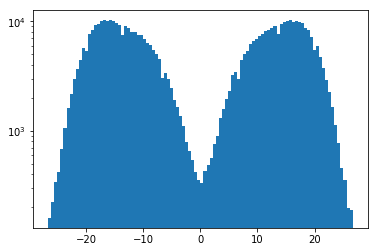

dz


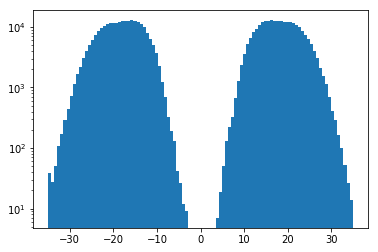

z0


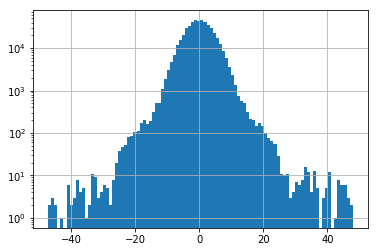

z0 res


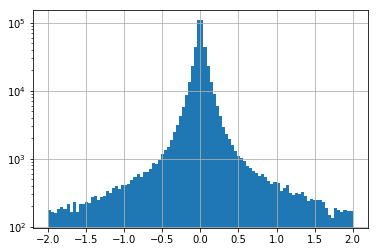

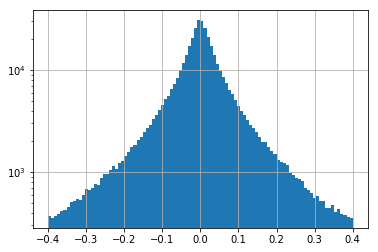

z0 pool


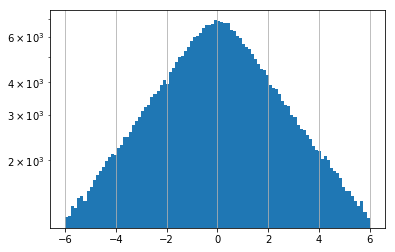

[ 3.07635086e+03 -4.96034081e-03 -1.29681200e+00  1.19053141e+00
  3.99064655e-03 -3.92301925e+00]


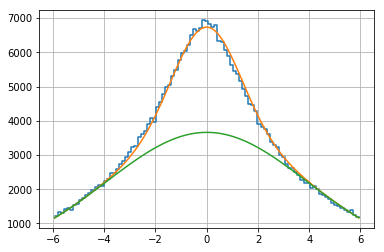

dr


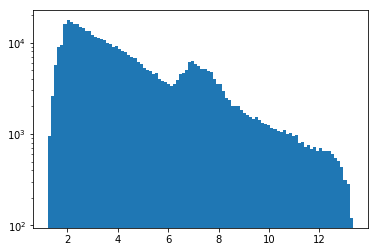

dphi zcut


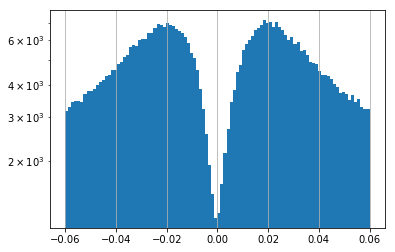

zinner zcut


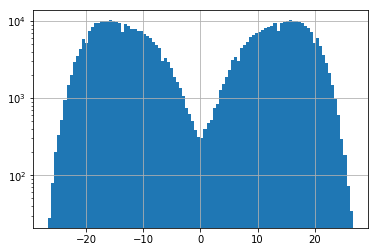

module


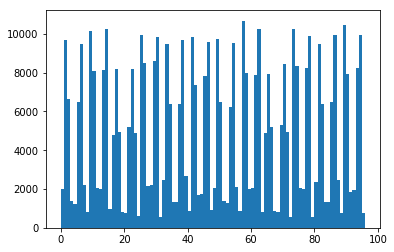

dysize


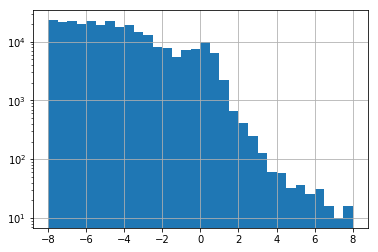

ysize


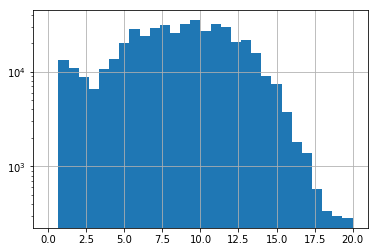

ys-pred


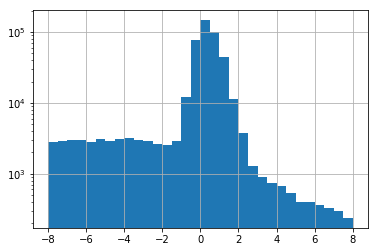

 
NEW PAIR 4 2 8
 
dphi


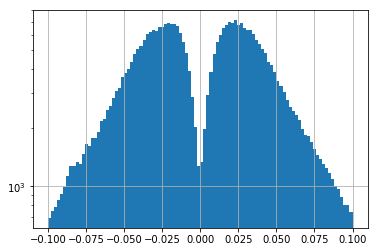

dphiNor


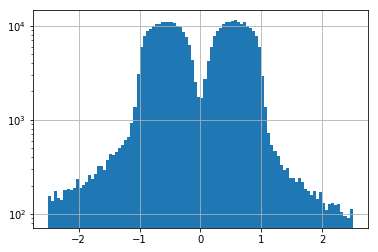

zinner


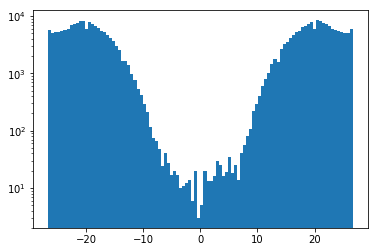

dz


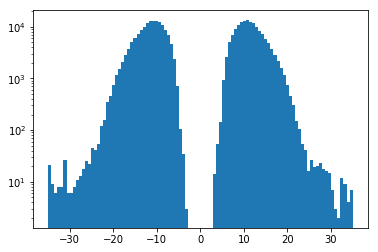

z0


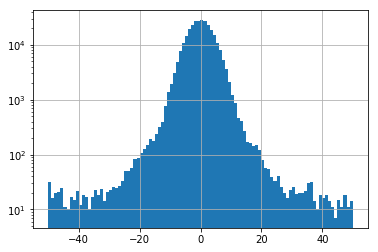

z0 res


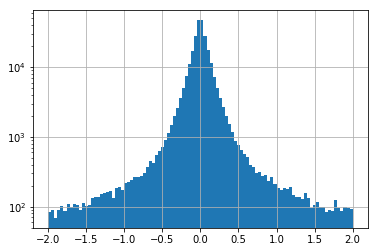

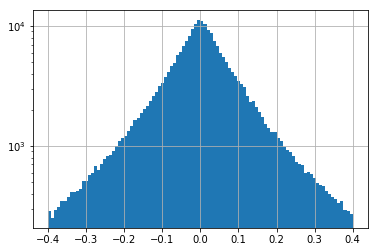

z0 pool


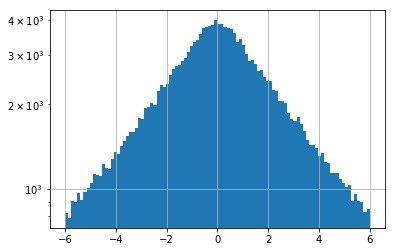

[ 1.67307205e+03 -1.04333205e-02 -1.28159947e+00  1.26970495e+00
  2.41935279e-02 -4.21667545e+00]


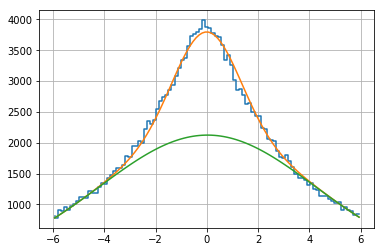

dr


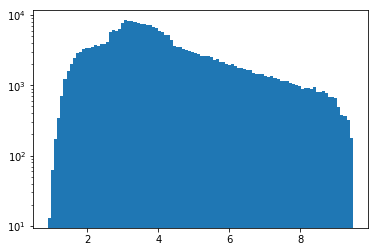

dphi zcut


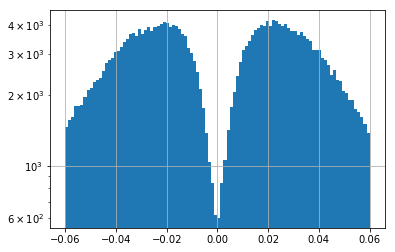

zinner zcut


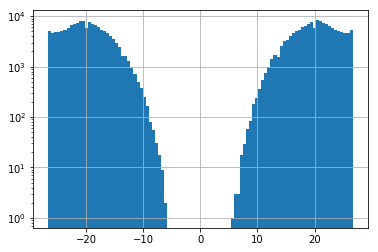

module


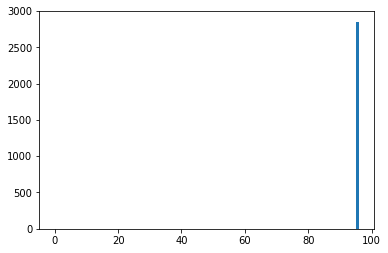

dysize


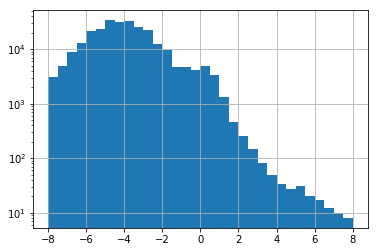

ysize


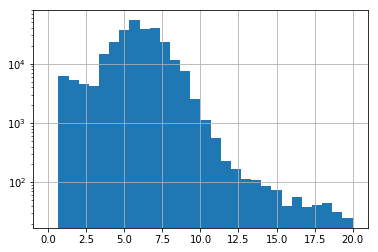

ys-pred


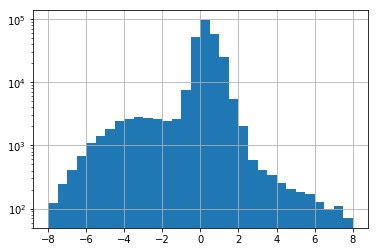

 
NEW PAIR 5 3 8
 
dphi


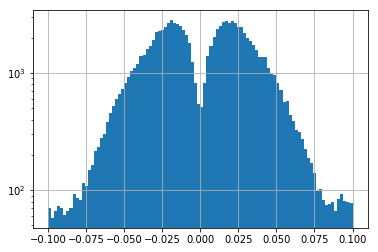

dphiNor


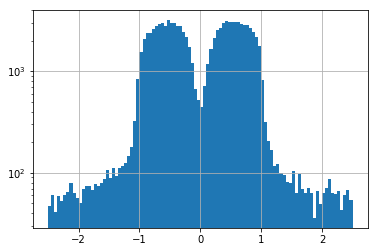

zinner


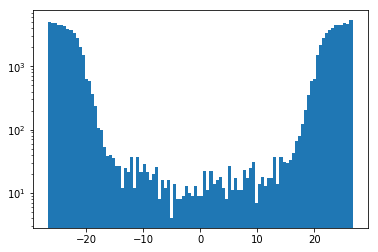

dz


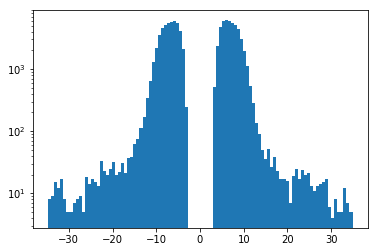

z0


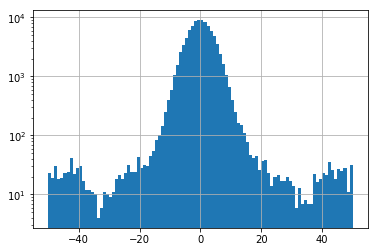

z0 res


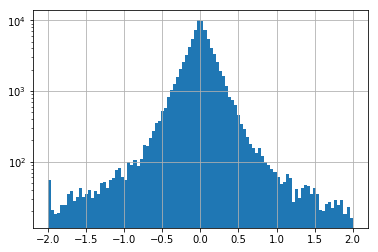

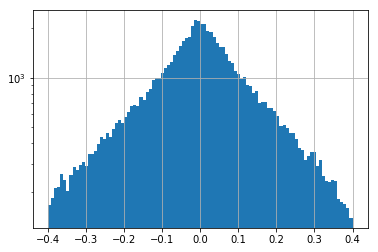

z0 pool


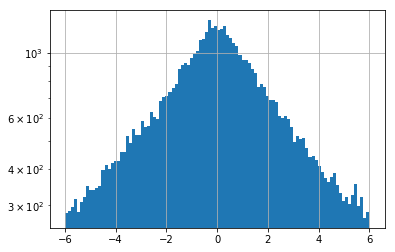

[ 5.43380754e+02  8.65342253e-03  1.14448018e+00  1.19834443e+00
 -2.96280044e-02  4.41515851e+00]


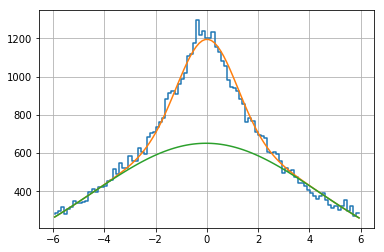

dr


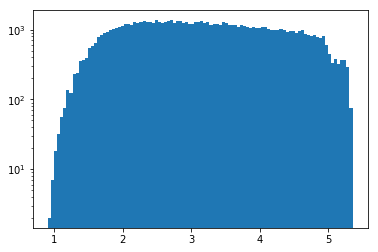

dphi zcut


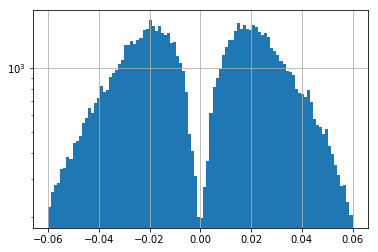

zinner zcut


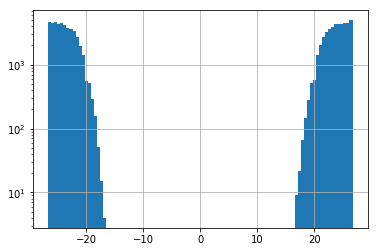

module


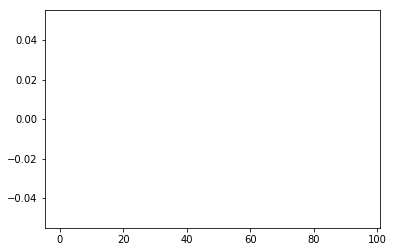

dysize


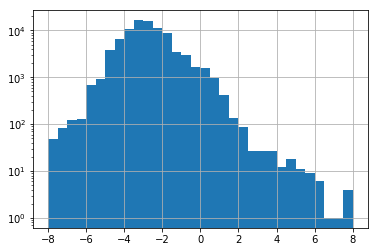

ysize


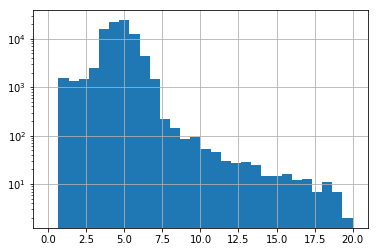

ys-pred


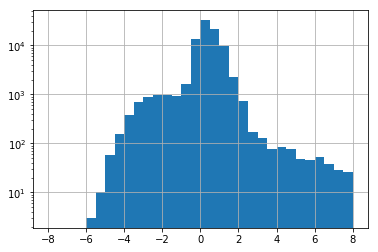

 
NEW PAIR 6 8 9
 
dphi


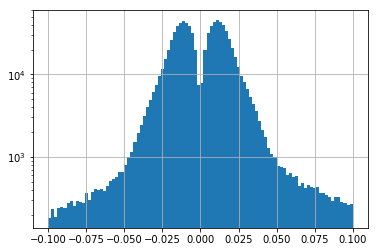

dphiNor


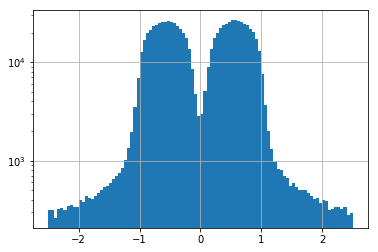

zinner


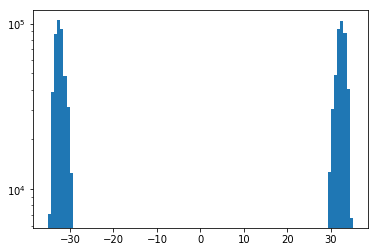

dz


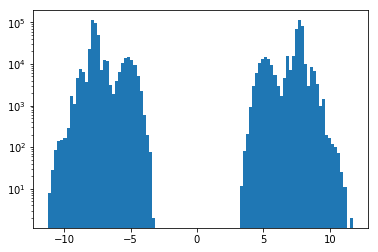

z0


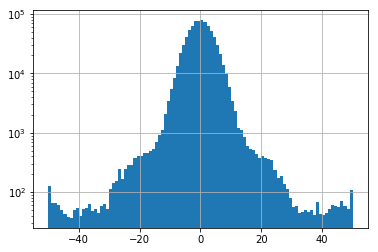

z0 res


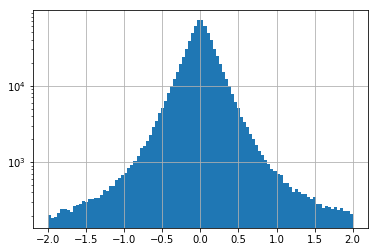

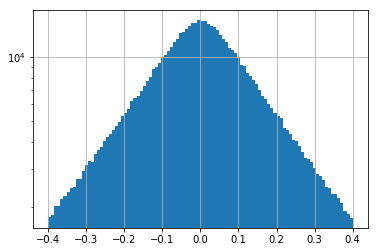

z0 pool


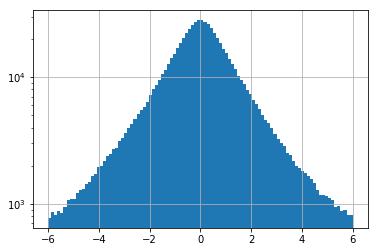

[ 1.96058411e+04  2.69575191e-04 -8.97209290e-01  3.33221137e-01
 -1.05808878e-02 -2.65094180e+00]


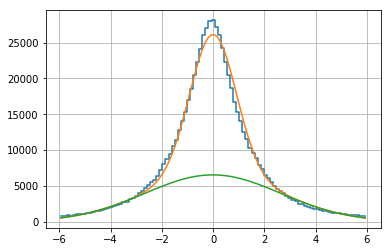

dr


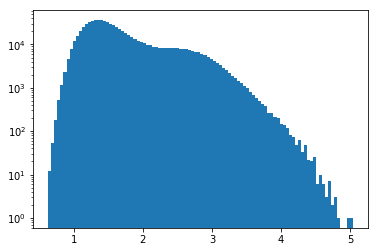

dphi zcut


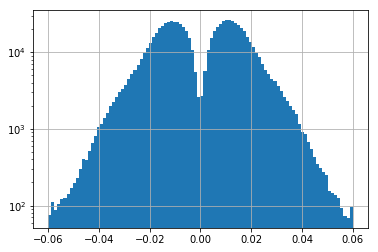

zinner zcut


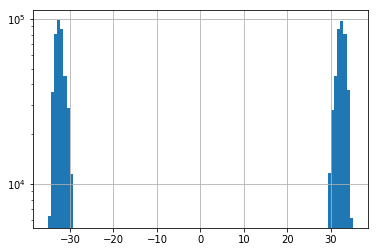

module


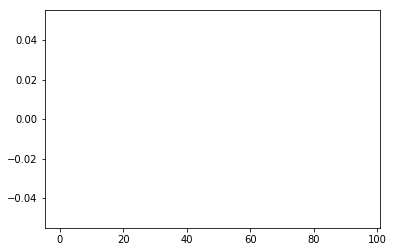

dysize


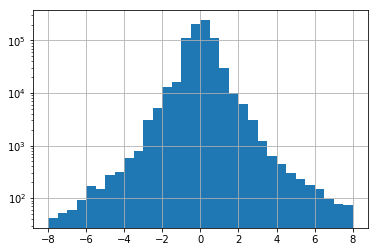

ysize


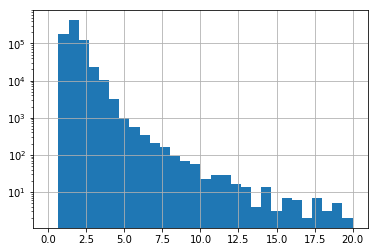

ys-pred


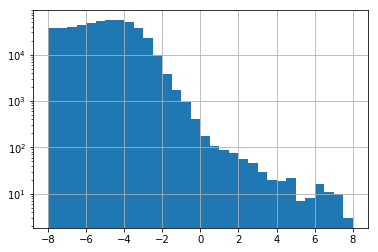

 
NEW PAIR 7 9 10
 
dphi


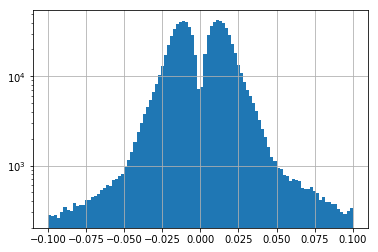

dphiNor


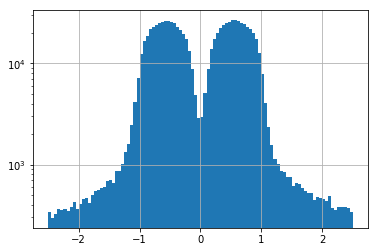

zinner


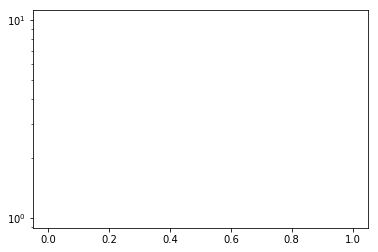

dz


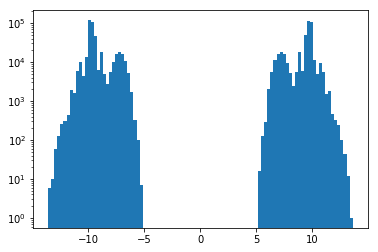

z0


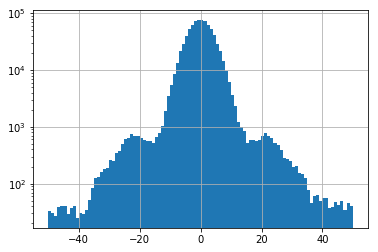

z0 res


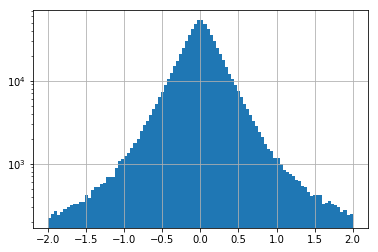

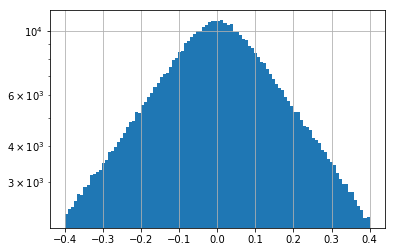

z0 pool


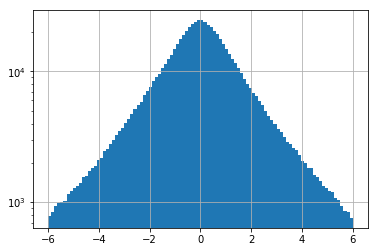

[ 1.63354716e+04  3.82546026e-04 -9.47794074e-01  4.25917841e-01
 -4.95682323e-03 -2.70019655e+00]


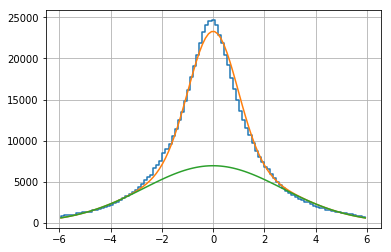

dr


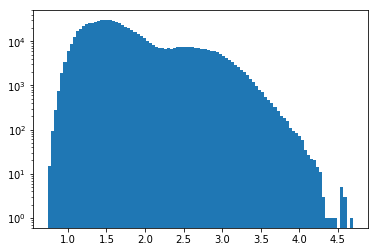

dphi zcut


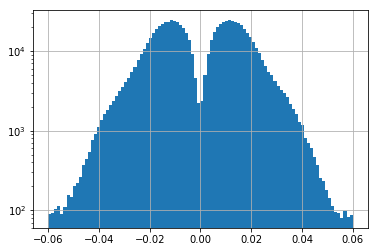

zinner zcut


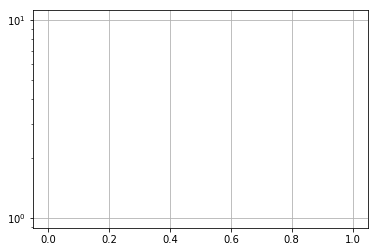

module


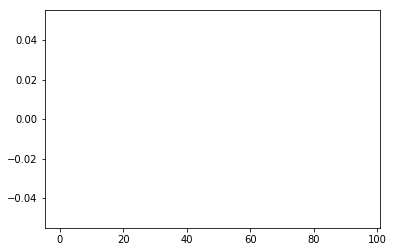

dysize


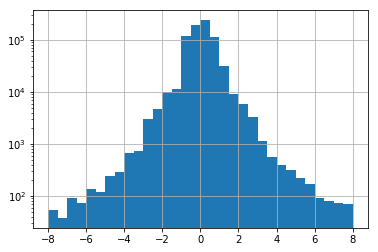

ysize


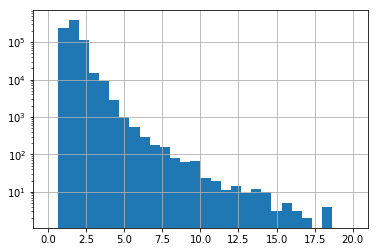

ys-pred


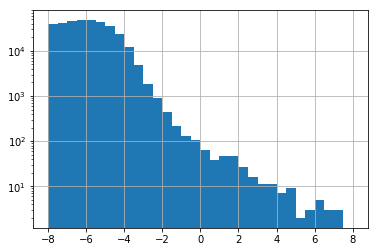

In [128]:
kp=0
for quad in lpairs :
  plotPairs(quad,400,kp)
  kp+=1